In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import HeNormal, Zeros
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report


In [ ]:
# prompt: グーグルドライブと連結
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# データの読み込み
data = pd.read_csv("/content/drive/MyDrive/A_comp/clustering_num.csv")

# 特徴量とターゲットの分割
X = data.drop(['churn','Customer_ID'], axis=1)
y = data['churn']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

スタンダード

In [ ]:
# データの準備
n_input = X_train.shape[1]  # 入力特徴量の数
n_hidden = 16  # 隠れ層のユニット数
n_output = 1   # 出力層のユニット数

# MLPモデルの定義
mlp = Sequential()

# 隠れ層の追加（入力層は省略し、最初の隠れ層でinput_shapeを指定）
mlp.add(Dense(units=100, input_shape=(n_input,), bias_initializer='zeros'))  # 最初の隠れ層
mlp.add(Dense(units=n_hidden, activation='relu', kernel_initializer=HeNormal(), bias_initializer='zeros'))  # 隠れ層
mlp.add(Dense(units=n_output, activation='sigmoid', kernel_initializer=HeNormal(), bias_initializer='zeros'))  # 出力層

# モデルのコンパイル
mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 早期停止の設定
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# モデルのトレーニング
hist = mlp.fit(X_train_scaled, y_train, batch_size=32, epochs=100,
               validation_data=(X_test_scaled, y_test),
               callbacks=[early_stopping],
               verbose=2)
# モデルの予測結果を取得
y_pred = (mlp.predict(X_test_scaled) > 0.5).astype("int32")  # 出力層がsigmoidなので、0.5をしきい値にする

# precision, recall, f1-scoreなどを表示
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2457/2457 - 8s - 3ms/step - accuracy: 0.5790 - loss: 0.6812 - val_accuracy: 0.5947 - val_loss: 0.6693
Epoch 2/100
2457/2457 - 9s - 4ms/step - accuracy: 0.5991 - loss: 0.6642 - val_accuracy: 0.5929 - val_loss: 0.6689
Epoch 3/100
2457/2457 - 9s - 4ms/step - accuracy: 0.6047 - loss: 0.6601 - val_accuracy: 0.6018 - val_loss: 0.6640
Epoch 4/100
2457/2457 - 6s - 3ms/step - accuracy: 0.6073 - loss: 0.6574 - val_accuracy: 0.5951 - val_loss: 0.6683
Epoch 5/100
2457/2457 - 9s - 3ms/step - accuracy: 0.6080 - loss: 0.6564 - val_accuracy: 0.6020 - val_loss: 0.6617
Epoch 6/100
2457/2457 - 7s - 3ms/step - accuracy: 0.6101 - loss: 0.6553 - val_accuracy: 0.6013 - val_loss: 0.6588
Epoch 7/100
2457/2457 - 4s - 2ms/step - accuracy: 0.6128 - loss: 0.6533 - val_accuracy: 0.6015 - val_loss: 0.6643
Epoch 8/100
2457/2457 - 5s - 2ms/step - accuracy: 0.6168 - loss: 0.6520 - val_accuracy: 0.6000 - val_loss: 0.6589
Epoch 9/100
2457/2457 - 7s - 3ms/step - accuracy: 0.6167 - loss: 0.6505 - val_accuracy: 

In [ ]:
def cross_validation(n_input, n_hidden, n_output, data):
    # 特徴量とターゲットの分割
    X = data.drop(['churn','Customer_ID'], axis=1)
    y = data['churn']

    # トレーニングデータとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 特徴量のスケーリング
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # K-Foldクロスバリデーションの設定
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5分割
    fold_accuracies = []  # 各foldの結果を格納するリスト
    best_model = None  # 最良モデルを保持するための変数

    # クロスバリデーション
    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # MLPモデルの定義
        mlp = Sequential()
        mlp.add(Dense(units=100, input_shape=(n_input,), bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.01)))  # 最初の隠れ層
        mlp.add(Dropout(0.3))  # ドロップアウトレイヤーを追加
        mlp.add(Dense(units=n_hidden, activation='relu', kernel_initializer=HeNormal(), bias_initializer='zeros'))  # 隠れ層
        mlp.add(Dropout(0.3))  # ドロップアウトレイヤーを追加
        mlp.add(Dense(units=n_output, activation='sigmoid', kernel_initializer=HeNormal(), bias_initializer='zeros'))  # 出力層

        # モデルのコンパイル
        mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

        # 早期停止の設定
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # モデルのトレーニング
        mlp.fit(X_train_fold, y_train_fold, batch_size=32, epochs=100,
                validation_data=(X_val_fold, y_val_fold),
                callbacks=[early_stopping],
                verbose=0)

        # モデルの評価 (バリデーションデータ)
        val_loss, val_accuracy = mlp.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_accuracies.append(val_accuracy)

        # 最良モデルを保持
        if best_model is None or val_accuracy > np.max([best_model[1]]):
            best_model = (mlp, val_accuracy)

    # クロスバリデーションの結果を出力
    print('各Foldの正確率:', [acc * 100 for acc in fold_accuracies])
    print('平均正確率:', np.mean(fold_accuracies) * 100)
    print("---------------------------")

    # 最良のモデルを取得
    final_model = best_model[0]

    # モデルのテストデータでの評価
    y_pred = (final_model.predict(X_test_scaled) > 0.5).astype("int32")

    # 評価指標の計算
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # 結果の表示
    print(f'テストデータでの精度: {accuracy}')
    print(f'テストデータでの再現率: {recall}')
    print(f'テストデータでの適合率: {precision}')
    print(classification_report(y_test, y_pred))
    print("================================================")

クロスバリデーション
隠れユニット数64


In [ ]:
# データの準備
n_input = X_train.shape[1]  # 入力特徴量の数
n_hidden = 64  # 隠れ層のユニット数
n_output = 1   # 出力層のユニット数

# K-Foldクロスバリデーションの設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5分割
fold_accuracies = []  # 各foldの結果を格納するリスト

# クロスバリデーション
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # MLPモデルの定義
    mlp = Sequential()
    mlp.add(Dense(units=100, input_shape=(n_input,), bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01)))  # 最初の隠れ層
    mlp.add(Dropout(0.3))  # ドロップアウトレイヤーを追加
    mlp.add(Dense(units=n_hidden, activation='relu', kernel_initializer=HeNormal(), bias_initializer='zeros'))  # 隠れ層
    mlp.add(Dropout(0.3))  # ドロップアウトレイヤーを追加
    mlp.add(Dense(units=n_output, activation='sigmoid', kernel_initializer=HeNormal(), bias_initializer='zeros'))  # 出力層

    # モデルのコンパイル
    mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # 早期停止の設定
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # モデルのトレーニング
    mlp.fit(X_train_fold, y_train_fold, batch_size=32, epochs=100,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stopping],
            verbose=0)

    # モデルの評価
    val_loss, val_accuracy = mlp.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(val_accuracy)

# クロスバリデーションの結果を出力
print('各Foldの正確率:', [acc * 100 for acc in fold_accuracies])
print('平均正確率:', np.mean(fold_accuracies) * 100)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

各Foldの正確率: [59.12993550300598, 58.506643772125244, 59.305429458618164, 59.19730067253113, 58.344995975494385]
平均正確率: 58.89686107635498


クロスバリデーション　隠れユニット数32

In [ ]:
def cross_validation_and_plot_metrics(n_input, n_hidden, n_output, data):
    # 特徴量とターゲットの分割
    X = data.drop(['churn','Customer_ID'], axis=1)
    y = data['churn']

    # トレーニングデータとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 特徴量のスケーリング
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # K-Foldクロスバリデーションの設定
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5分割
    fold_accuracies = []  # 各foldの結果を格納するリスト
    best_model = None  # 最良モデルを保持するための変数
    hist = None  # 最後のモデルの学習履歴を保持

    # クロスバリデーション
    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # MLPモデルの定義
        mlp = Sequential()
        mlp.add(Dense(units=100, input_shape=(n_input,), bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.01)))  # 最初の隠れ層
        mlp.add(Dropout(0.3))  # ドロップアウトレイヤーを追加
        mlp.add(Dense(units=n_hidden, activation='relu', kernel_initializer=HeNormal(), bias_initializer='zeros'))  # 隠れ層
        mlp.add(Dropout(0.3))  # ドロップアウトレイヤーを追加
        mlp.add(Dense(units=n_output, activation='sigmoid', kernel_initializer=HeNormal(), bias_initializer='zeros'))  # 出力層

        # モデルのコンパイル
        mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

        # 早期停止の設定
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # モデルのトレーニング
        hist = mlp.fit(X_train_fold, y_train_fold, batch_size=32, epochs=100,
                       validation_data=(X_val_fold, y_val_fold),
                       callbacks=[early_stopping],
                       verbose=0)

        # モデルの評価 (バリデーションデータ)
        val_loss, val_accuracy, val_recall, val_precision = mlp.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_accuracies.append(val_accuracy)

        # 最良モデルを保持
        if best_model is None or val_accuracy > np.max([best_model[1]]):
            best_model = (mlp, val_accuracy)

    # クロスバリデーションの結果を出力
    print('各Foldの正確率:', [acc * 100 for acc in fold_accuracies])
    print('平均正確率:', np.mean(fold_accuracies) * 100)
    print("---------------------------")

    # 最良のモデルを取得
    final_model = best_model[0]

    # モデルのテストデータでの評価
    y_pred = (final_model.predict(X_test_scaled) > 0.5).astype("int32")

    # 評価指標の計算
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # 結果の表示
    print(f'テストデータでの精度: {accuracy}')
    print(f'テストデータでの再現率: {recall}')
    print(f'テストデータでの適合率: {precision}')
    print(classification_report(y_test, y_pred))

    # モデルの学習履歴をプロット
    # 精度のグラフ
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid()
    plt.show()

    # 損失のグラフ
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid()
    plt.show()

    # 再現率のグラフ（もし使用している場合）
    if 'val_recall' in hist.history:
        plt.plot(hist.history['val_recall'])
        plt.title('Model recall')
        plt.ylabel('Recall')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper left')
        plt.grid()
        plt.show()

    # 適合率のグラフ（もし使用している場合）
    if 'val_precision' in hist.history:
        plt.plot(hist.history['val_precision'])
        plt.title('Model precision')
        plt.ylabel('Precision')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper left')
        plt.grid()
        plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

各Foldの正確率: [59.2126190662384, 58.78649353981018, 59.80791449546814, 59.38175916671753, 58.50400924682617]
平均正確率: 59.13855910301209
---------------------------
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
テストデータでの精度: 0.591940571893762
テストデータでの再現率: 0.6071501951921101
テストデータでの適合率: 0.5848011082525233
              precision    recall  f1-score   support

         0.0       0.60      0.58      0.59      9920
         1.0       0.58      0.61      0.60      9734

    accuracy                           0.59     19654
   macro avg       0.59      0.59      0.59     19654
weighted avg       0.59      0.59      0.59     19654



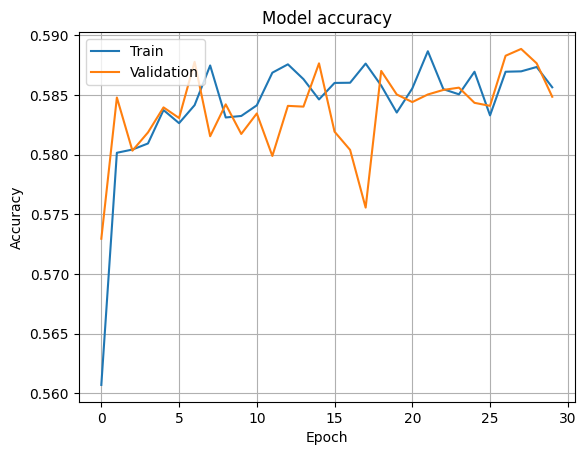

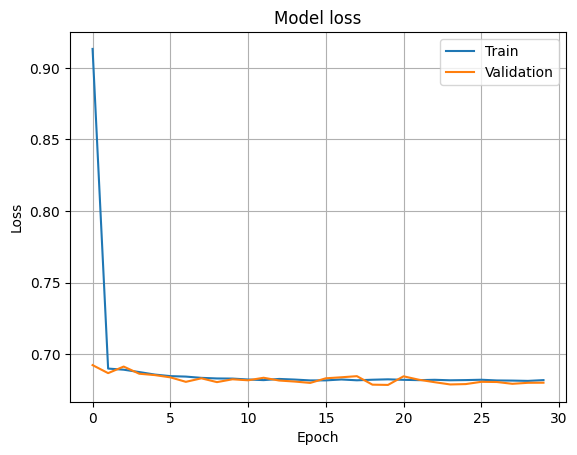

In [ ]:
# データの準備
n_input = X_train.shape[1]  # 入力特徴量の数
n_hidden = 40  # 隠れ層のユニット数
n_output = 1   # 出力層のユニット数
cross_validation_and_plot_metrics(n_input,n_hidden,n_output,data)